# Quantum Gate calibration using Model Free Reinforcement Learning

We extend the state preparation scheme to a gate calibration scheme by providing multiple input states to the target.

In [792]:
import numpy as np
import matplotlib.pyplot as plt
import json
from itertools import product
import os
import sys
from tqdm import tqdm
from IPython.display import clear_output
from time import sleep
from typing import Optional, Tuple, List, Union, Dict, Sequence

module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)
from quantumenvironment import QuantumEnvironment
from helper_functions import perform_standard_calibrations

from qiskit.providers.fake_provider.fake_backend import FakeBackend, FakeBackendV2
# Qiskit Quantum Information, for fidelity benchmarking
from qiskit.quantum_info.operators import SparsePauliOp, Operator, pauli_basis
from qiskit.quantum_info.operators.measures import average_gate_fidelity, state_fidelity, process_fidelity
from qiskit.quantum_info.states import DensityMatrix, Statevector
from qiskit.transpiler import Layout
from qiskit_aer.backends.aerbackend import AerBackend
from qiskit_aer.primitives import Estimator as Aer_Estimator
# Qiskit dynamics for pulse simulation (& benchmarking)
from qiskit_dynamics import DynamicsBackend, Solver
from qiskit_dynamics.array import Array, wrap
from qiskit_dynamics.models import HamiltonianModel
# Qiskit Experiments for generating reliable baseline for complex gate calibrations / state preparations
from qiskit_experiments.framework import BatchExperiment
from qiskit_experiments.library import ProcessTomography
from qiskit_experiments.library.tomography.basis import PauliPreparationBasis  # , Pauli6PreparationBasis
from qiskit_ibm_runtime import Estimator as Runtime_Estimator, IBMBackend as Runtime_Backend, Options, Session

# Qiskit imports for building RL environment (circuit level)
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.extensions import CXGate, XGate
from qiskit.opflow import Zero, One, Plus, Minus, H, I, X, CX, S, Z
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.distributions import MultivariateNormal

In [793]:
"""

""
Class to generate a RL environment suitable for usage with PyTorch agents, leveraging Qiskit modules to simulate
quantum system (could also include QUA code in the future)

Author: Arthur Strauss
Created on 28/11/2022
""

# For compatibility for options formatting between Estimators.
import json
from itertools import product
from typing import Dict, Union, Optional, List, Callable

import numpy as np
# Qiskit imports
from qiskit import pulse, schedule
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate, CircuitInstruction
# Qiskit Estimator Primitives: for computing Pauli expectation value sampling easily
from qiskit.primitives import BaseEstimator, Estimator, BackendEstimator
# Qiskit backends
from qiskit.providers import BackendV1, BackendV2
from qiskit.providers.fake_provider.fake_backend import FakeBackend, FakeBackendV2
# Qiskit Quantum Information, for fidelity benchmarking
from qiskit.quantum_info.operators import SparsePauliOp, Operator, pauli_basis
from qiskit.quantum_info.operators.measures import average_gate_fidelity, state_fidelity, process_fidelity
from qiskit.quantum_info.states import DensityMatrix, Statevector
from qiskit.transpiler import Layout
from qiskit_aer.backends.aerbackend import AerBackend
from qiskit_aer.primitives import Estimator as Aer_Estimator
# Qiskit dynamics for pulse simulation (& benchmarking)
from qiskit_dynamics import DynamicsBackend, Solver
from qiskit_dynamics.array import Array, wrap
from qiskit_dynamics.models import HamiltonianModel
# Qiskit Experiments for generating reliable baseline for complex gate calibrations / state preparations
from qiskit_experiments.framework import BatchExperiment
from qiskit_experiments.library import ProcessTomography
from qiskit_experiments.library.tomography.basis import PauliPreparationBasis  # , Pauli6PreparationBasis
from qiskit_ibm_runtime import Estimator as Runtime_Estimator, IBMBackend as Runtime_Backend, Options, Session

from qconfig import QiskitConfig

# from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon, EchoedCrossResonance

# QUA imports
# from qualang_tools.bakery.bakery import baking
# from qm.qua import *
# from qm.QuantumMachinesManager import QuantumMachinesManager

Estimator_type = Union[Aer_Estimator, Runtime_Estimator, Estimator, BackendEstimator]
Backend_type = Union[BackendV1, BackendV2]

def _calculate_chi_target_state(target_state: Dict, n_qubits: int):
    
    Calculate for all P
    :param target_state: Dictionary containing info on target state (name, density matrix)
    :param n_qubits: Number of qubits
    :return: Target state supplemented with appropriate "Chi" key
    
    assert 'dm' in target_state, 'No input data for target state, provide DensityMatrix'
    d = 2 ** n_qubits
    Pauli_basis = pauli_basis(num_qubits=n_qubits)
    # Calculate the target state vector in Pauli basis
    target_state["Chi"] = np.array([np.trace(np.array(target_state["dm"].to_operator())
                                             @ Pauli_basis[k].to_matrix()).real
                                    for k in range(d ** 2)])
    # Real part is taken to convert it in good format,
    # but imaginary part is always 0. as dm is hermitian and Pauli is traceless
    return target_state


def _define_target(target: Dict):
    if "register" in target:
        assert isinstance(target["register"], (List, QuantumRegister)), "Register should be of type List[int] " \
                                                                        "or Quantum Register"
    tgt_register = target.get("register", None)
    if isinstance(tgt_register, List):
        q_register = QuantumRegister(len(tgt_register))
        layout = Layout({q_register[i]: tgt_register[i] for i in range(len(tgt_register))})
    else:  # QuantumRegister or None
        q_register = tgt_register
        layout = None

    if 'gate' not in target and 'circuit' not in target and 'dm' not in target:
        raise KeyError("No target provided, need to have one of the following: 'gate' for gate calibration,"
                       " 'circuit' or 'dm' for state preparation")
    if ('gate' in target and 'circuit' in target) or ('gate' in target and 'dm' in target):
        raise KeyError("Cannot have simultaneously a gate target and a state target")
    if "circuit" in target or "dm" in target:
        target["target_type"] = "state"
        if 'circuit' in target:
            assert isinstance(target["circuit"], QuantumCircuit), "Provided circuit is not a qiskit.QuantumCircuit " \
                                                                  "object"
            target["dm"] = DensityMatrix(target["circuit"])

        assert 'dm' in target, 'no DensityMatrix or circuit argument provided to target dictionary'
        assert isinstance(target["dm"], DensityMatrix), 'Provided dm is not a DensityMatrix object'
        dm: DensityMatrix = target["dm"]
        n_qubits = dm.num_qubits

        if q_register is None:
            q_register = QuantumRegister(n_qubits)

        if layout is None:
            layout = Layout.generate_trivial_layout(q_register)

        return _calculate_chi_target_state(target, n_qubits), "state", q_register, n_qubits, layout

    elif "gate" in target:
        target["target_type"] = "gate"
        assert isinstance(target["gate"], Gate), "Provided gate is not a qiskit.circuit.Gate operation"
        gate: Gate = target["gate"]
        n_qubits = target["gate"].num_qubits
        if q_register is None:
            q_register = QuantumRegister(n_qubits)
        if layout is None:
            layout = Layout.generate_trivial_layout(q_register)

        assert gate.num_qubits == len(q_register), f"Target gate number of qubits ({gate.num_qubits}) " \
                                                   f"incompatible with indicated 'register' ({len(tgt_register)})"
        if 'input_states' not in target:
            target['input_states'] = [{"circuit": PauliPreparationBasis().circuit(s).decompose()}
                                      for s in product(range(4), repeat=len(tgt_register))]

            # target['input_states'] = [{"dm": Pauli6PreparationBasis().matrix(s),
            #                            "circuit": CircuitOp(Pauli6PreparationBasis().circuit(s).decompose())}
            #                           for s in product(range(6), repeat=len(tgt_register))]

        for i, input_state in enumerate(target["input_states"]):
            if 'circuit' not in input_state:
                raise KeyError("'circuit' key missing in input_state")
            assert isinstance(input_state["circuit"], QuantumCircuit), "Provided circuit is not a" \
                                                                       "qiskit.QuantumCircuit object"

            input_circuit: QuantumCircuit = input_state['circuit']
            input_state['dm'] = DensityMatrix(input_circuit)

            state_target_circuit = QuantumCircuit(q_register)
            state_target_circuit.append(input_circuit.to_instruction(), q_register)
            state_target_circuit.append(CircuitInstruction(gate, q_register))

            input_state['target_state'] = {"dm": DensityMatrix(state_target_circuit),
                                           "circuit": state_target_circuit,
                                           "target_type": "state"}
            input_state['target_state'] = _calculate_chi_target_state(input_state['target_state'], n_qubits)
        return target, "gate", q_register, n_qubits, layout
    else:
        raise KeyError('target type not identified, must be either gate or state')


class QuantumEnvironment:

    def __init__(self, target: Dict, abstraction_level: str = 'circuit',
                 Qiskit_config: Optional[QiskitConfig] = None,
                 QUA_config: Optional[Dict] = None,
                 sampling_Pauli_space: int = 10, n_shots: int = 1, c_factor: float = 0.5):
        ""
        Class for building quantum environment for RL agent aiming to perform a state preparation task.

        :param target: control target of interest (can be either a gate to be calibrated or a state to be prepared)
            Target should be a Dict containing target type ('gate' or 'state') as well as necessary fields to initiate
            the calibration (cf. example)
        :param abstraction_level: Circuit or pulse level parametrization of action space
        :param Qiskit_config: Dictionary containing all info for running Qiskit program (i.e. service, backend,
            options, parametrized_circuit)
        :param QUA_config: Dictionary containing all info for running a QUA program
        :param sampling_Pauli_space: Number of samples to build fidelity estimator for one action
        :param n_shots: Number of shots to sample for one specific computation (action/Pauli expectation sampling)
        :param c_factor: Scaling factor for reward normalization
        ""

        assert abstraction_level == 'circuit' or abstraction_level == 'pulse', 'Abstraction layer can be either pulse' \
                                                                               ' or circuit'
        self.abstraction_level: str = abstraction_level
        if Qiskit_config is None and QUA_config is None:
            raise AttributeError("QuantumEnvironment requires one software configuration (can be Qiskit or QUA based)")
        if Qiskit_config is not None and QUA_config is not None:
            raise AttributeError("Cannot provide simultaneously a QUA setup and a Qiskit config ")
        elif Qiskit_config is not None:
            self._config_type = "Qiskit"
            self._config: Qiskit_config = Qiskit_config
            self.target, self.target_type, self.tgt_register, self._n_qubits, self._layout = _define_target(target)

            self._d = 2 ** self.n_qubits
            self.c_factor = c_factor
            self.sampling_Pauli_space = sampling_Pauli_space
            self.n_shots = n_shots
            self.Pauli_ops = pauli_basis(num_qubits=self._n_qubits)

            self.backend: Optional[Backend_type] = Qiskit_config.backend
            self.parametrized_circuit_func: Callable = Qiskit_config.parametrized_circuit
            estimator_options: Optional[Union[Options, Dict]] = Qiskit_config.estimator_options

            if self.abstraction_level == "circuit":  # Either state-vector simulation (native) or AerBackend provided
                if isinstance(self.backend, (AerBackend, FakeBackend, FakeBackendV2)):
                    # Estimator taking noise model into consideration, have to provide an AerBackend
                    # TODO: Extract from TranspilationOptions a dict that can go in following definition
                    self._estimator: Estimator_type = Aer_Estimator(backend_options=self.backend.options,
                                                                   transpile_options={'initial_layout': self._layout},
                                                                   approximation=True)
                else:  # No backend specified, ideal state-vector simulation
                    self._estimator: Estimator_type = Estimator(options={"initial_layout": self._layout})

            else: # Pulse level abstraction
                if not isinstance(self.backend, (Runtime_Backend, DynamicsBackend)):
                    raise TypeError("Backend must be either DynamicsBackend or Qiskit Runtime backend if pulse level"
                                    "abstraction is selected (Aer Pulse simulator deprecated")


                if isinstance(self.backend, DynamicsBackend):
                    import jax
                    jit = wrap(jax.jit, decorator=True)
                    self._estimator: Estimator_type = BackendEstimator(self.backend, skip_transpilation= False)
                    self._estimator.set_transpile_options(initial_layout=self.layout)
                    if self.config.do_calibrations:
                        calibration_files: List[str] = Qiskit_config.calibration_files
                        self.calibrations, self.exp_results = perform_standard_calibrations(self.backend,
                                                                                            calibration_files)
                    self._benchmark_backend = self.backend
                else:
                    if hasattr(self.backend, "configuration"):
                        self._benchmark_backend = DynamicsBackend.from_backend(self.backend,
                                                                           subsystem_list=target["register"])
                # For benchmarking the gate at each epoch, set tools for Pulse level simulator
                if Qiskit_config.solver is not None:
                    self.solver: Solver = Qiskit_config.solver
                else:
                    self.solver: Solver = self._benchmark_backend.options.solver  # Custom Solver
                # Can describe noisy channels, if none provided, pick Solver associated to DynamicsBackend by default
                self.model_dim, self.channel_freq  = self.solver.model.dim, Qiskit_config.channel_freq
                if isinstance(self.solver.model, HamiltonianModel):
                    self.y_0 = Array(np.eye(self.model_dim))
                    self.ground_state = Array(np.array([1.0] + [0.0] * (self.model_dim - 1)))
                else:
                    self.y_0 = Array(np.eye(self.model_dim ** 2))
                    self.ground_state = Array(np.array([1.0] + [0.0] * (self.model_dim ** 2 - 1)))

            if isinstance(self.backend, Runtime_Backend):  # Real backend, or Simulation backend from Runtime Service
                self._estimator: Estimator_type = Runtime_Estimator(session=Session(self.backend.service, self.backend),
                                                                   options=estimator_options)
                if self.estimator.options.transpilation['initial_layout'] is None:
                    self.estimator.options.transpilation['initial_layout']=self._layout.get_physical_bits()

        elif QUA_config is not None:
            raise AttributeError("QUA compatibility not yet implemented")
            # self._config_type = "QUA"
            # self._config = QUA_config

            # TODO: Add a QUA program

        # Data storage for TF-Agents or plotting
        self._step_tracker = 0
        self.action_history = []
        self.density_matrix_history = []
        self.reward_history = []
        self.qc_history = []
        if self.target_type == 'gate':
            self.process_fidelity_history = []
            self.avg_fidelity_history = []
            self.built_unitaries = []
        else:
            self.state_fidelity_history = []


    def perform_action(self, actions: torch.Tensor, do_benchmark: bool = True):
        ""
        Execute quantum circuit with parametrized amplitude, retrieve measurement result 
        and assign rewards accordingly
        :param actions: action vector to execute on quantum system
        :param do_benchmark: Indicates if actual fidelity computation should be done on 
        top of reward computation
        :return: Reward table (reward for each run in the batch)
        ""

        qc = QuantumCircuit(self.tgt_register)
        parametrized_circ = QuantumCircuit(self.tgt_register)
        angles, batch_size = actions.numpy(), len(actions)
        self.action_history.append(angles)

        if self.target_type == 'gate':
            index = torch.randint(len(self.target["input_states"]), (1,)).item()
            input_state = self.target["input_states"][index]
            target_state = input_state["target_state"]
            qc.append(input_state["circuit"].to_instruction(), self.tgt_register)

        else:  # State preparation task
            target_state = self.target

        # Use PyTorch's Categorical distribution instead of TensorFlow's
        distribution = torch.distributions.Categorical(probs=torch.tensor(target_state["Chi"] ** 2))
        k_samples = distribution.sample(sample_shape=(self.sampling_Pauli_space,))
        # print('k samples: ', k_samples)
        pauli_index, pauli_shots = torch.unique(k_samples, return_counts=True)
        k_samples = k_samples.numpy()
        #print('k samples type: ', type(k_samples))
        #print('k samples shape: ', k_samples.shape)

        reward_factors_list = [self.c_factor * target_state["Chi"][p] / (self._d * distribution.probs[p]) for p in pauli_index]
        reward_factor = torch.round(torch.tensor(reward_factors_list), decimals=5)
        #print('reward factor: ', reward_factor)

        reward_factor = reward_factor.numpy() 
        pauli_index = pauli_index.numpy()

        #print('self.Pauli_ops ', self.Pauli_ops)
        #print('reward_factor. ', reward_factor)
        #print('pauli index ', pauli_index)

        assert len(reward_factor) == len(pauli_index), "Mismatched lengths"

        # Construct the list for SparsePauliOp
        observables = SparsePauliOp.from_list([(self.Pauli_ops[p].to_label(), float(r)) 
                                               for p, r in zip(pauli_index, reward_factor)])
        # print('observables: ', observables)


        self.parametrized_circuit_func(parametrized_circ)
        qc_list = [parametrized_circ.bind_parameters(angle_set) for angle_set in angles]
        self.qc_history.append(qc_list)

        if do_benchmark:
            self._store_benchmarks(qc_list)

        self.parametrized_circuit_func(qc)

        if isinstance(self.estimator, Runtime_Estimator):
            job = self.estimator.run(circuits=[qc] * batch_size, observables=[observables] * batch_size,
                                parameter_values=angles, shots=self.sampling_Pauli_space * self.n_shots,
                                job_tags=[f"rl_qoc_step{self._step_tracker}"])
        else:
            job = self.estimator.run(circuits=[qc] * batch_size, observables=[observables] * batch_size,
                                    parameter_values=angles, shots=self.sampling_Pauli_space * self.n_shots)

        self._step_tracker += 1
        reward_table = job.result().values
        self.reward_history.append(reward_table)
        assert len(reward_table) == batch_size

        return torch.tensor(reward_table) # Shape [batchsize]



    def _store_benchmarks(self, qc_list: List[QuantumCircuit]):
        ""
        Method to store in lists all relevant data to assess performance of training (fidelity information)
        ""

        # Circuit list for each action of the batch
        if self.abstraction_level == 'circuit':

            q_state_list = [Statevector.from_instruction(qc) for qc in qc_list]
            density_matrix = DensityMatrix(np.mean([q_state.to_operator().to_matrix() for q_state in q_state_list],
                                                   axis=0))
            self.density_matrix_history.append(density_matrix)

            if self.target_type == 'state':
                self.state_fidelity_history.append(state_fidelity(self.target["dm"], density_matrix))
            else:  # Gate calibration task
                q_process_list = [Operator(qc) for qc in qc_list]

                prc_fidelity = np.mean([process_fidelity(q_process, Operator(self.target["gate"]))
                                        for q_process in q_process_list])
                avg_fidelity = np.mean([average_gate_fidelity(q_process, Operator(self.target["gate"]))
                                        for q_process in q_process_list])
                self.built_unitaries.append(q_process_list)
                self.process_fidelity_history.append(prc_fidelity)  # Avg process fidelity over the action batch
                self.avg_fidelity_history.append(avg_fidelity)  # Avg gate fidelity over the action batch
                # for i, input_state in enumerate(self.target["input_states"]):
                #     output_states = [DensityMatrix(Operator(qc) @ input_state["dm"] @ Operator(qc).adjoint())
                #                      for qc in qc_list]
                #     self.input_output_state_fidelity_history[i].append(
                #         np.mean([state_fidelity(input_state["target_state"]["dm"],
                #                                 output_state) for output_state in output_states]))
        elif self.abstraction_level == 'pulse':
            # Pulse simulation
            schedule_list = [schedule(qc, backend=self.backend, dt=self.backend.target.dt) for qc in qc_list]
            unitaries = self._simulate_pulse_schedules(schedule_list)
            # TODO: Line below yields an error if simulation is not done over a set of qubit (fails if third level of
            # TODO: transmon is simulated), adapt the target gate operator accordingly.
            unitaries = [Operator(np.array(unitary.y[0])) for unitary in unitaries]

            if self.target_type == 'state':
                density_matrix = DensityMatrix(np.mean([Statevector.from_int(0, dims=self._d).evolve(unitary)
                                                        for unitary in unitaries]))
                self.state_fidelity_history.append(state_fidelity(self.target["dm"], density_matrix))
            else:
                self.process_fidelity_history.append(np.mean([process_fidelity(unitary, self.target["gate"])
                                                              for unitary in unitaries]))
                self.avg_fidelity_history.append(np.mean([average_gate_fidelity(unitary, self.target["gate"])
                                                          for unitary in unitaries]))
            self.built_unitaries.append(unitaries)

    def gate_fidelity_from_process_tomography(self, qc_list: List[QuantumCircuit]):
        ""
        Extract average gate and process fidelities from batch of Quantum Circuit for target gate
        ""
        # Process tomography
        assert self.target_type == 'gate', "Target must be of type gate"
        batch_size = len(qc_list)

        exps = BatchExperiment([ProcessTomography(qc, backend=self.backend, physical_qubits=self.tgt_register)
                                for qc in qc_list])

        results = exps.run().block_for_results()
        process_results = [results.child_data(i).analysis_results(0) for i in range(batch_size)]
        Choi_matrices = [matrix.value for matrix in process_results]
        avg_gate_fidelity = np.mean([average_gate_fidelity(Choi_matrix, Operator(self.target["gate"]))
                                     for Choi_matrix in Choi_matrices])
        prc_fidelity = np.mean([process_fidelity(Choi_matrix, Operator(self.target["gate"]))
                                for Choi_matrix in Choi_matrices])

        self.process_fidelity_history.append(prc_fidelity)
        self.avg_fidelity_history.append(avg_gate_fidelity)
        return avg_gate_fidelity, prc_fidelity

    def _simulate_pulse_schedules(self, schedule_list: List[Union[pulse.Schedule, pulse.ScheduleBlock]]):
        ""
        Method used to simulate pulse schedules, jit compatible
        ""
        time_f = self.backend.target.dt * schedule_list[0].duration
        unitaries = self.solver.solve(
            t_span=Array([0.0, time_f]),
            y0=self.y_0,
            t_eval=[time_f],
            signals=schedule_list,
            method="jax_odeint",
        )

        return unitaries

    def clear_history(self):
        self.qc_history.clear()
        self.action_history.clear()
        self.reward_history.clear()
        if self.target_type == 'gate':
            self.avg_fidelity_history.clear()
            self.process_fidelity_history.clear()
            self.built_unitaries.clear()

        else:
            self.state_fidelity_history.clear()
            self.density_matrix_history.clear()

    def close(self) -> None:
        if isinstance(self.estimator, Runtime_Estimator):
            self.estimator.session.close()

    def __repr__(self):
        string = f"QuantumEnvironment composed of {self._n_qubits} qubits, \n"
        string += f"Defined target: {self.target_type} " \
                  f"({self.target.get('gate', None) if not None else self.target['dm']})\n"
        string += f"Physical qubits: {self.target['register']}\n"
        string += f"Backend: {self.backend},\n"
        string += f"Abstraction level: {self.abstraction_level},\n"
        string += f"Run options: N_shots ({self.n_shots}), Sampling_Pauli_space ({self.sampling_Pauli_space}), \n"
        return string

    @property
    def n_qubits(self):
        return self._n_qubits

    @n_qubits.setter
    def n_qubits(self, n_qubits):
        assert isinstance(n_qubits, int) and n_qubits > 0, "n_qubits must be a positive integer"
        self._n_qubits = n_qubits

    @property
    def layout(self):
        return self._layout

    @layout.setter
    def layout(self, layout: Layout):
        self._layout = layout

    @property
    def config_type(self):
        return self._config_type

    @property
    def config(self):
        return self._config

    @property
    def estimator(self) -> Estimator_type:
        return self._estimator

    @estimator.setter
    def estimator(self, estimator: BaseEstimator):
        self._estimator = estimator

    @property
    def step_tracker(self):
        return self._step_tracker
    @step_tracker.setter
    def step_tracker(self, step:int):
        assert step >= 0, 'step must be positive integer'
        self._step_tracker = step

    def to_json(self):
        return json.dumps({"n_qubits": self.n_qubits, "config": self._config,
                           "abstraction_level": self.abstraction_level,
                           "sampling_Pauli_space": self.sampling_Pauli_space,
                           "n_shots": self.n_shots,
                           "target_type": self.target_type,
                           "target": self.target,
                           "c_factor": self.c_factor,
                           "reward_history": self.reward_history,
                           "action_history": self.action_history,
                           "fidelity_history": self.avg_fidelity_history if self.target_type == "gate"
                           else self.state_fidelity_history,

                           })

    @classmethod
    def from_json(cls, json_str):
        ""Return a MyCustomClass instance based on the input JSON string.""

        class_info = json.loads(json_str)
        abstraction_level = class_info["abstraction_level"]
        target = class_info["target"]
        n_shots = class_info["n_shots"]
        c_factor = class_info["c_factor"]
        sampling_Pauli_space = class_info["sampling_Pauli_space"]
        config = class_info["config"]
        q_env = cls(target, abstraction_level, config, None, sampling_Pauli_space,
                    n_shots, c_factor)
        q_env.reward_history = class_info["reward_history"]
        q_env.action_history = class_info["action_history"]
        if class_info["target_type"] == "gate":
            q_env.avg_fidelity_history = class_info["fidelity_history"]
        else:
            q_env.state_fidelity_history = class_info["fidelity_history"]
        return q_env"""

'\n\n""\nClass to generate a RL environment suitable for usage with PyTorch agents, leveraging Qiskit modules to simulate\nquantum system (could also include QUA code in the future)\n\nAuthor: Arthur Strauss\nCreated on 28/11/2022\n""\n\n# For compatibility for options formatting between Estimators.\nimport json\nfrom itertools import product\nfrom typing import Dict, Union, Optional, List, Callable\n\nimport numpy as np\n# Qiskit imports\nfrom qiskit import pulse, schedule\nfrom qiskit.circuit import QuantumCircuit, QuantumRegister, Gate, CircuitInstruction\n# Qiskit Estimator Primitives: for computing Pauli expectation value sampling easily\nfrom qiskit.primitives import BaseEstimator, Estimator, BackendEstimator\n# Qiskit backends\nfrom qiskit.providers import BackendV1, BackendV2\nfrom qiskit.providers.fake_provider.fake_backend import FakeBackend, FakeBackendV2\n# Qiskit Quantum Information, for fidelity benchmarking\nfrom qiskit.quantum_info.operators import SparsePauliOp, Operat

In [794]:
# Ansatz function, could be at pulse level or circuit level
def apply_parametrized_circuit(qc: QuantumCircuit):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    :param qc: Quantum Circuit instance to add the gates on
    :param params: Qiskit ParameterVector
    :return:
    """
    # qc.num_qubits
    params = ParameterVector('params', 7)
    qc.u(2 * np.pi * params[0], 2 * np.pi * params[1], 2 * np.pi * params[2], 0)
    qc.u(2 * np.pi * params[3], 2 * np.pi * params[4], 2 * np.pi * params[5], 1)
    qc.rzx(2 * np.pi * params[6], 0, 1)

# Defining the QuantumEnvironment

Below, we set the RL environment parameters, that is how we describe our quantum system. Below, we can choose to go through the use of Qiskit Runtime, or to speed things up by using the local CPU and a state-vector simulator to get measurement outcomes based on the ansatz circuit defined above. The Environment is defined as a class object called QuantumEnvironment.

## Generic information characterizing the quantum system

The algorithm is built upon Qiskit modules. To specify how to address our quantum system of interest, we therefore adopt the IBM approach to define a quantum backend, on which qubits are defined and can be accessed via control actions and measurements.

The cell below specifies:
- ```qubit_tgt_register```: List of qubit indices which are specifically addressed by controls , namely the ones for which we intend to calibrate a gate upon or steer them in a specific quantum state. Note that this list could include less qubits than the total number of qubits, which can be useful when one wants to take into account crosstalk effects emerging from nearest-neigbor coupling.
- ```sampling_Paulis```: number of Pauli observables  to be sampled from the system: the algorithm relies on the ability to process measurement outcomes to estimate the expectation value of different Pauli operators. The more observables we provide for sampling, the more properties we are able to deduce with accuracy about the actual state that was created when applying our custom controls. For a single qubit, the possible Pauli operators are $\sigma_0=I$, $\sigma_x=X$, $\sigma_y=Y$, $\sigma_z=Z$. For a general multiqubit system, the Pauli observables are tensor products of those single qubit Pauli operators. The algorithm will automatically estimate which observables are the most relevant to sample based on the provided target. The probability distribution from which those observables are sampled is derived from the Direct Fidelity Estimation (equation 3, https://link.aps.org/doi/10.1103/PhysRevLett.106.230501) algorithm. 
- ```N_shots```: Indicates how many measurements shall be done for each provided circuit (that is a specific combination of an action vector and a Pauli observable to be sampled)
- The dimension of the action vector: Indicates the number of pulse/circuit parameters that characterize our parametrized quantum circuit.
- ```estimator_options```: Options of the Qiskit Estimator primitive. The Estimator is the Qiskit module enabling an easy computation of Pauli expectation values. One can set options to make this process more reliable (typically by doing some error mitigation techniques in post-processing). Works only with Runtime Backend at the moment
- ```abstraction_level``` chosen to encode our quantum circuit. One can choose here to stick to the usual circuit model of quantum computing, by using the ```QuantumCircuit``` objects from Qiskit and therefore set the ```abstraction_level``` to ```"circuit"```. However, depending on the task at hand, one can also prefer to use a pulse description of all the operations in our circuit. This is possible by using resources of another module of Qiskit called Qiskit Dynamics. In this case, one should define the ansatz circuit above in a pulse level fashion, and the simulation done at the Hamiltonian level, and not only via statevector calculations. In this notebook we set the ```abstraction_level``` to ```"circuit"```. Another notebook at the pulse level is available in the repo.

In [795]:
qubit_tgt_register = [0, 1]  # Choose which qubits of the QPU you want to address 
sampling_Paulis = 200
N_shots = 1  # Number of shots for sampling the quantum computer for each action vector

n_actions = 7  # Choose how many control parameters in pulse/circuit parametrization
# Define Qiskit ParameterVector of length n_actions being equal to the number of trainable circuit parameters
# circuit_params = ParameterVector('theta', n_actions) 

seed = 4000
estimator_options = {'seed_simulator': seed,'resilience_level': 0}

Choose below which IBM Backend to use. As we are dealing with circuit level implementation, we can look for a backend supporting Qiskit Runtime (could be a cloud simulator, or real backend) or simply set backend to None and rely on the Estimator primitive based on statevector simulation. In either case, we need access to one Estimator primitive to run the algorithm, as the feedback from the measurement outcomes is done by calculating Pauli expectation values.

## 1. Setting up a Quantum Backend

### Real backend initialization

Uncomment the cell below to declare a Qiskit Runtime backend. You need an internet connection and an IBM Id account to access this.

In [796]:
"""
Real backend initialization:
Run this cell only if intending to use a real backend,
where Qiskit Runtime is enabled
"""
backend_name = 'ibm_perth'

#service = QiskitRuntimeService(channel='ibm_quantum')
#runtime_backend = service.get_backend(backend_name)
#estimator_options = {'resilience_level': 0}


### Simulation backend initialization
If you want to run the algorithm over a simulation, you can use Qiskit BaseEstimator, which does not need any real backend and relies on statevector simulation.

Note that you could also define a custom Aer noise model and use an Aer version of the Estimator primitive. This feature will become available soon.


In [797]:
"""
If using Qiskit native Estimator primitive
(statevector simulation)
"""
no_backend = None

### Choose backend and define Qiskit config dictionary
Below, set the Backend that you would like to run among the above defined backend.
Then define the config gathering all the components enabling the definition of the ```QuantumEnvironment```.



In [798]:
backend = no_backend

In [799]:
# Wrap all info in one dict Qiskit_setup
Qiskit_setup = QiskitConfig(parametrized_circuit=apply_parametrized_circuit, backend=backend,
                            estimator_options=estimator_options)

## 2. Define quantum target: State preparation or Gate calibration

The target of our optimal control task can be of two different types:
1.  An arbitrary quantum state to prepare with high accuracy
2. A Quantum Gate to be calibrated in a noise-robust manner

Both targets are dictionaries that are identified with a key stating their ```target_type```, which can be either ```"state"``` or ```"gate"```.

For a gate target $G$, one can add the target quantum gate with a ```"gate"``` argument specifying a specific instance of a Qiskit ```Gate``` object. Here, we settle for calibrating a ```CXGate()```.
Moreover, a gate calibration requires a set of input states $\{|s_i\rangle \}$ to be provided, such that the agent can try to set the actions such that the fidelity between the anticipated ideal target state (calculated as  $G|s_i\rangle$) and the output state are simultaneously maximized. To ensure a correlation between the average reward computed from the measurement outcomes and the average gate fidelity, the provided set of input states must be tomographically complete.

For a state target, one can provide, similarly to an input state, an ideal circuit to prepare it (```"circuit": QuantumCircuit```, or a density matrix (key ```"dm": DensityMatrix```).

Another important key that should figure in the dictionary is the ```"register"``` indicating the qubits indices that should be addressed by this target, i.e. upon which qubits should the target be engineered.


In [800]:
# Target gate: CNOT gate

circuit_Plus_i = S @ H
circuit_Minus_i = S @ H @ X
cnot_target = {
    "target_type": "gate",
    "gate": CXGate("CNOT"),
    "register": qubit_tgt_register
}

In [801]:
target = cnot_target

## 3. Declare QuantumEnvironment object
Running the box below declares the QuantumEnvironment instance.


In [802]:
# Define quantum environment
q_env = QuantumEnvironment(target=target, abstraction_level="circuit",
                           Qiskit_config=Qiskit_setup,
                           sampling_Pauli_space=sampling_Paulis, n_shots=N_shots, c_factor=0.25)

# Defining the RL agent: PPO

### Define the ActorCriticNetwork (Neural Network)

In [803]:
class ActorCritic(nn.Module):
    def __init__(self, input_shape: Tuple, hidden_units: Union[List, Tuple], n_actions: int,
                 actor_critic_together: bool = True,
                 hidden_units_critic: Optional[Union[List, Tuple]] = None):
        super(ActorCritic, self).__init__()
        
        self.input_layer = nn.Linear(input_shape[0], hidden_units[0])
        self.relu = nn.ReLU()
        
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(hidden_units)):
            self.hidden_layers.append(nn.Linear(hidden_units[i - 1], hidden_units[i]))
            # self.hidden_layers.append(nn.ReLU())
        
        self.mean_param = nn.Linear(hidden_units[-1], n_actions)
        self.sigma_param = nn.Linear(hidden_units[-1], n_actions)
        
        if actor_critic_together:
            self.critic_output = nn.Linear(hidden_units[-1], 1)
        
        self.actor_critic_together = actor_critic_together
        
        if not actor_critic_together:
            assert hidden_units_critic is not None, "Network structure for critic network not provided"
            self.input_critic = nn.Linear(input_shape[0], hidden_units_critic[0])
            self.critic_layers = nn.ModuleList()
            for i in range(1, len(hidden_units_critic)):
                self.critic_layers.append(nn.Linear(hidden_units_critic[i - 1], hidden_units_critic[i]))
                # self.critic_layers.append(nn.ReLU())
            self.critic_output = nn.Linear(hidden_units_critic[-1], 1)
    
    def forward(self, x_actor, x_critic=None):
        x_actor = self.relu(self.input_layer(x_actor))
        for layer in self.hidden_layers:
            x_actor = self.relu(layer(x_actor))
        
        mean_param = torch.tanh(self.mean_param(x_actor))
        sigma_param = torch.nn.functional.softplus(self.sigma_param(x_actor))
        
        if self.actor_critic_together:
            critic_output = self.critic_output(x_actor)
            return mean_param, sigma_param, critic_output
        else:
            x_critic = self.relu(self.input_critic(x_critic))
            for layer in self.critic_layers:
                x_critic = self.relu(layer(x_critic))
            critic_output = self.critic_output(x_critic)
            return mean_param, sigma_param, critic_output

In [804]:
"""class ActorCritic(nn.Module):
    def __init__(self, input_shape: Tuple, hidden_units: Union[List, Tuple], n_actions: int,
                 actor_critic_together: bool = True,
                 hidden_units_critic: Optional[Union[List, Tuple]] = None):
        super(ActorCritic, self).__init__()
        
        # Actor network
        self.actor_layers = nn.ModuleList()
        self.actor_layers.append(nn.Linear(input_shape[0], hidden_units[0]))
        self.actor_layers.append(nn.ReLU())
        
        for i in range(1, len(hidden_units)):
            self.actor_layers.append(nn.Linear(hidden_units[i - 1], hidden_units[i]))
            self.actor_layers.append(nn.ReLU())
        self.mean_param = nn.Linear(hidden_units[-1], n_actions)
        self.sigma_param = nn.Linear(hidden_units[-1], n_actions)
        
        # Critic network
        if actor_critic_together:
            self.critic_layers = self.actor_layers  # Share layers with actor
        else:
            assert hidden_units_critic is not None, "Network structure for critic network not provided"
            self.critic_layers = nn.ModuleList()
            self.critic_layers.append(nn.Linear(input_shape[0], hidden_units_critic[0]))
            self.critic_layers.append(nn.ReLU())
            for i in range(1, len(hidden_units_critic)):
                self.critic_layers.append(nn.Linear(hidden_units_critic[i - 1], hidden_units_critic[i]))
                self.critic_layers.append(nn.ReLU())
        self.critic_output = nn.Linear(hidden_units_critic[-1] if not actor_critic_together else hidden_units[-1], 1)
    
    def forward(self, x):
        # Actor forward pass
        for layer in self.actor_layers:
            x = layer(x)
        mean_param = torch.tanh(self.mean_param(x))
        sigma_param = F.softplus(self.sigma_param(x))
        
        # Critic forward pass
        x_critic = x
        for layer in self.critic_layers:
            x_critic = layer(x_critic)
        critic_output = self.critic_output(x_critic)
        
        return mean_param, sigma_param, critic_output"""

'class ActorCritic(nn.Module):\n    def __init__(self, input_shape: Tuple, hidden_units: Union[List, Tuple], n_actions: int,\n                 actor_critic_together: bool = True,\n                 hidden_units_critic: Optional[Union[List, Tuple]] = None):\n        super(ActorCritic, self).__init__()\n        \n        # Actor network\n        self.actor_layers = nn.ModuleList()\n        self.actor_layers.append(nn.Linear(input_shape[0], hidden_units[0]))\n        self.actor_layers.append(nn.ReLU())\n        \n        for i in range(1, len(hidden_units)):\n            self.actor_layers.append(nn.Linear(hidden_units[i - 1], hidden_units[i]))\n            self.actor_layers.append(nn.ReLU())\n        self.mean_param = nn.Linear(hidden_units[-1], n_actions)\n        self.sigma_param = nn.Linear(hidden_units[-1], n_actions)\n        \n        # Critic network\n        if actor_critic_together:\n            self.critic_layers = self.actor_layers  # Share layers with actor\n        else:\n    

In [805]:
"""class ActorCritic(nn.Module):
    def __init__(self, input_shape: Tuple, hidden_units: Union[List, Tuple], n_actions: int,
                 actor_critic_together: bool = True,
                 hidden_units_critic: Optional[Union[List, Tuple]] = None):
        super(ActorCritic, self).__init__()
        
        # Actor Network
        self.input_layer = nn.Linear(input_shape[0], hidden_units[0])
        self._init_weights(self.input_layer, 0.1, 0.5)
        
        self.hidden_layers = nn.ModuleList()
        for i, units in enumerate(hidden_units[1:]):
            layer = nn.Linear(hidden_units[i], units)
            self._init_weights(layer, 0.1, 0.5)
            self.hidden_layers.append(layer)
        
        self.mean_param = nn.Linear(hidden_units[-1], n_actions)
        self.sigma_param = nn.Linear(hidden_units[-1], n_actions)
        
        # Critic Network
        if actor_critic_together:
            self.critic_output = nn.Linear(hidden_units[-1], 1)
        else:
            assert hidden_units_critic is not None, "Network structure for critic network not provided"
            self.input_layer_critic = nn.Linear(input_shape[0], hidden_units_critic[0])
            self._init_weights(self.input_layer_critic, 0.1, 0.5)
            
            self.hidden_layers_critic = nn.ModuleList()
            for i, units in enumerate(hidden_units_critic[1:]):
                layer = nn.Linear(hidden_units_critic[i], units)
                self._init_weights(layer, 0.1, 0.5)
                self.hidden_layers_critic.append(layer)
            
            self.critic_output = nn.Linear(hidden_units_critic[-1], 1)
        
        self.actor_critic_together = actor_critic_together

    def _init_weights(self, layer, std, bias_mean):
        nn.init.normal_(layer.weight, mean=0, std=std)
        nn.init.normal_(layer.bias, mean=bias_mean, std=1)

    def forward(self, x):
        x_actor = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x_actor = F.relu(layer(x_actor))
        
        mean_param = torch.tanh(self.mean_param(x_actor))
        sigma_param = F.softplus(self.sigma_param(x_actor))
        
        if self.actor_critic_together:
            critic_output = self.critic_output(x_actor)
            return mean_param, sigma_param, critic_output
        else:
            x_critic = F.relu(self.input_layer_critic(x))
            for layer in self.hidden_layers_critic:
                x_critic = F.relu(layer(x_critic))
            critic_output = self.critic_output(x_critic)
            return mean_param, sigma_param, critic_output"""

'class ActorCritic(nn.Module):\n    def __init__(self, input_shape: Tuple, hidden_units: Union[List, Tuple], n_actions: int,\n                 actor_critic_together: bool = True,\n                 hidden_units_critic: Optional[Union[List, Tuple]] = None):\n        super(ActorCritic, self).__init__()\n        \n        # Actor Network\n        self.input_layer = nn.Linear(input_shape[0], hidden_units[0])\n        self._init_weights(self.input_layer, 0.1, 0.5)\n        \n        self.hidden_layers = nn.ModuleList()\n        for i, units in enumerate(hidden_units[1:]):\n            layer = nn.Linear(hidden_units[i], units)\n            self._init_weights(layer, 0.1, 0.5)\n            self.hidden_layers.append(layer)\n        \n        self.mean_param = nn.Linear(hidden_units[-1], n_actions)\n        self.sigma_param = nn.Linear(hidden_units[-1], n_actions)\n        \n        # Critic Network\n        if actor_critic_together:\n            self.critic_output = nn.Linear(hidden_units[-1], 1

In [806]:
def select_optimizer(params: np.ndarray, lr: float, optimizer: str = 'Adam', grad_clip: Optional[float] = None,
                     concurrent_optimization: bool = True, lr2: Optional[float] = None):
          
    if concurrent_optimization:
        if optimizer == 'Adam':
            optimizer1 = optim.Adam(params, lr=lr)
            optimizer2 = optim.Adam(params, lr=lr2) if lr2 is not None else None
            return optimizer1, optimizer2
        elif optimizer == 'SGD':
            optimizer1 = optim.SGD(params, lr=lr)
            optimizer2 = optim.SGD(params, lr=lr2) if lr2 is not None else None
            return optimizer1, optimizer2
    else:
        if optimizer == 'Adam':
            return optim.Adam(params, lr=lr) if grad_clip is None else optim.Adam(params, lr=lr, weight_decay=grad_clip)
        elif optimizer == 'SGD':
            return optim.SGD(params, lr=lr) if grad_clip is None else optim.SGD(params, lr=lr, weight_decay=grad_clip)
        

In [807]:
"""
-----------------------------------------------------------------------------------------------------
Hyperparameters for RL agent
-----------------------------------------------------------------------------------------------------
"""
%time

# Usage example:
n_qubits = 2
input_dim = n_qubits + 1
input_shape = (input_dim,)  # Replace 'input_dim' with your actual input dimension
hidden_units = [20, 20, 30]  # Replace with your desired hidden units
actor_critic_together = True  # Set to True or False as needed
hidden_units_critic = [20, 20, 20]  # Replace with critic network hidden units if actor_critic_together is False

model = ActorCritic(input_shape, hidden_units, n_actions, actor_critic_together, hidden_units_critic)
summary(model, input_shape)

n_epochs = 1000  # Number of epochs
batchsize = 300  # Batch size (iterate over a bunch of actions per policy to estimate expected return)
opti = "Adam"  # Optimizer choice

eta = 0.0018  # Learning rate for policy update step
eta_2 = None  # Learning rate for critic (value function) update step

use_PPO = True

epsilon = 0.01  # Parameter for clipping value (PPO)
grad_clip = 0.02
critic_loss_coeff = 0.5
optimizer = select_optimizer(params=model.parameters(), lr=eta, optimizer=opti, grad_clip=grad_clip, concurrent_optimization=False, lr2=eta_2)
sigma_eps = 1e-3  # for numerical stability

init_msmt = np.zeros((1, input_dim))  # Here no feedback involved, so measurement sequence is always the same

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]              80
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 20]             420
              ReLU-4                   [-1, 20]               0
            Linear-5                   [-1, 30]             630
              ReLU-6                   [-1, 30]               0
            Linear-7                    [-1, 7]             217
            Linear-8                    [-1, 7]             217
            Linear-9                    [-1, 1]              31
Total params: 1,595
Trainable params: 1,595
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated To

In [808]:
# Plotting tools
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

visualization_steps = 20  # For visualization frequency
%matplotlib inline

## Run algorithm

In [809]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [810]:
"""init_msmt_tensor = torch.tensor(init_msmt, dtype=torch.float32)

# Assuming network is now a PyTorch model and init_msmt is a tensor
mu_old, sigma_old, _ = model(init_msmt_tensor)
mu_old = mu_old[0].detach()  # Detach to make it a non-trainable tensor
sigma_old = sigma_old[0].detach()

avg_return = np.zeros(n_epochs)
fidelities = np.zeros(n_epochs)

for i in range(n_epochs):

    old_distrib = MultivariateNormal(mu_old, torch.diag(sigma_old))
    
    # Zero the gradients
    optimizer.zero_grad()

    mu, sigma, b = model(init_msmt_tensor)
    mu = mu.squeeze(0)
    sigma = sigma.squeeze(0)
    b = b.squeeze(0)

    policy_distrib = MultivariateNormal(mu, torch.diag(sigma))
    
    action_vector = torch.clamp(policy_distrib.sample([batchsize]), -1., 1.).detach()  # detach stops the gradient

    reward = q_env.perform_action(action_vector)

    advantage = torch.tensor(reward) - b

    if use_PPO:
        ratio = policy_distrib.log_prob(action_vector).exp() / (old_distrib.log_prob(action_vector).exp() + 1e-6)
        actor_loss = -torch.mean(torch.min(advantage * ratio, advantage * torch.clamp(ratio, 1 - epsilon, 1 + epsilon)))
    else:  # REINFORCE algorithm
        actor_loss = -torch.mean(advantage * policy_distrib.log_prob(action_vector))

    critic_loss = torch.mean(advantage ** 2)
    combined_loss = actor_loss + critic_loss_coeff * critic_loss

    # Compute gradients
    combined_loss.backward()

    # For PPO, update old parameters to have access to "old" policy
    if use_PPO:
        mu_old = mu.detach()
        sigma_old = sigma.detach()

    avg_return[i] = np.mean(q_env.reward_history, axis=1)[i]
    fidelities[i] = q_env.avg_fidelity_history[i]
    print("Gate Fidelity", fidelities[i])
    
    if i % visualization_steps == 0:
        from IPython.display import clear_output
        clear_output(wait=True)  # for animation
        fig, ax = plt.subplots()
        ax.plot(np.arange(1, n_epochs, 20), avg_return[0:-1:visualization_steps], '-.', label='Average return')
        ax.plot(np.arange(1, n_epochs, 20), fidelities[0:-1:visualization_steps], label='Average Gate Fidelity')
        ax.set_xlabel("Epoch")
        ax.set_ylabel("State Fidelity")
        ax.legend()
        plt.show()
        print("Maximum fidelity reached so far:", np.max(fidelities), "at Epoch", np.argmax(fidelities))

    # Update parameters
    optimizer.step()"""

'init_msmt_tensor = torch.tensor(init_msmt, dtype=torch.float32)\n\n# Assuming network is now a PyTorch model and init_msmt is a tensor\nmu_old, sigma_old, _ = model(init_msmt_tensor)\nmu_old = mu_old[0].detach()  # Detach to make it a non-trainable tensor\nsigma_old = sigma_old[0].detach()\n\navg_return = np.zeros(n_epochs)\nfidelities = np.zeros(n_epochs)\n\nfor i in range(n_epochs):\n\n    old_distrib = MultivariateNormal(mu_old, torch.diag(sigma_old))\n    \n    # Zero the gradients\n    optimizer.zero_grad()\n\n    mu, sigma, b = model(init_msmt_tensor)\n    mu = mu.squeeze(0)\n    sigma = sigma.squeeze(0)\n    b = b.squeeze(0)\n\n    policy_distrib = MultivariateNormal(mu, torch.diag(sigma))\n    \n    action_vector = torch.clamp(policy_distrib.sample([batchsize]), -1., 1.).detach()  # detach stops the gradient\n\n    reward = q_env.perform_action(action_vector)\n\n    advantage = torch.tensor(reward) - b\n\n    if use_PPO:\n        ratio = policy_distrib.log_prob(action_vector).

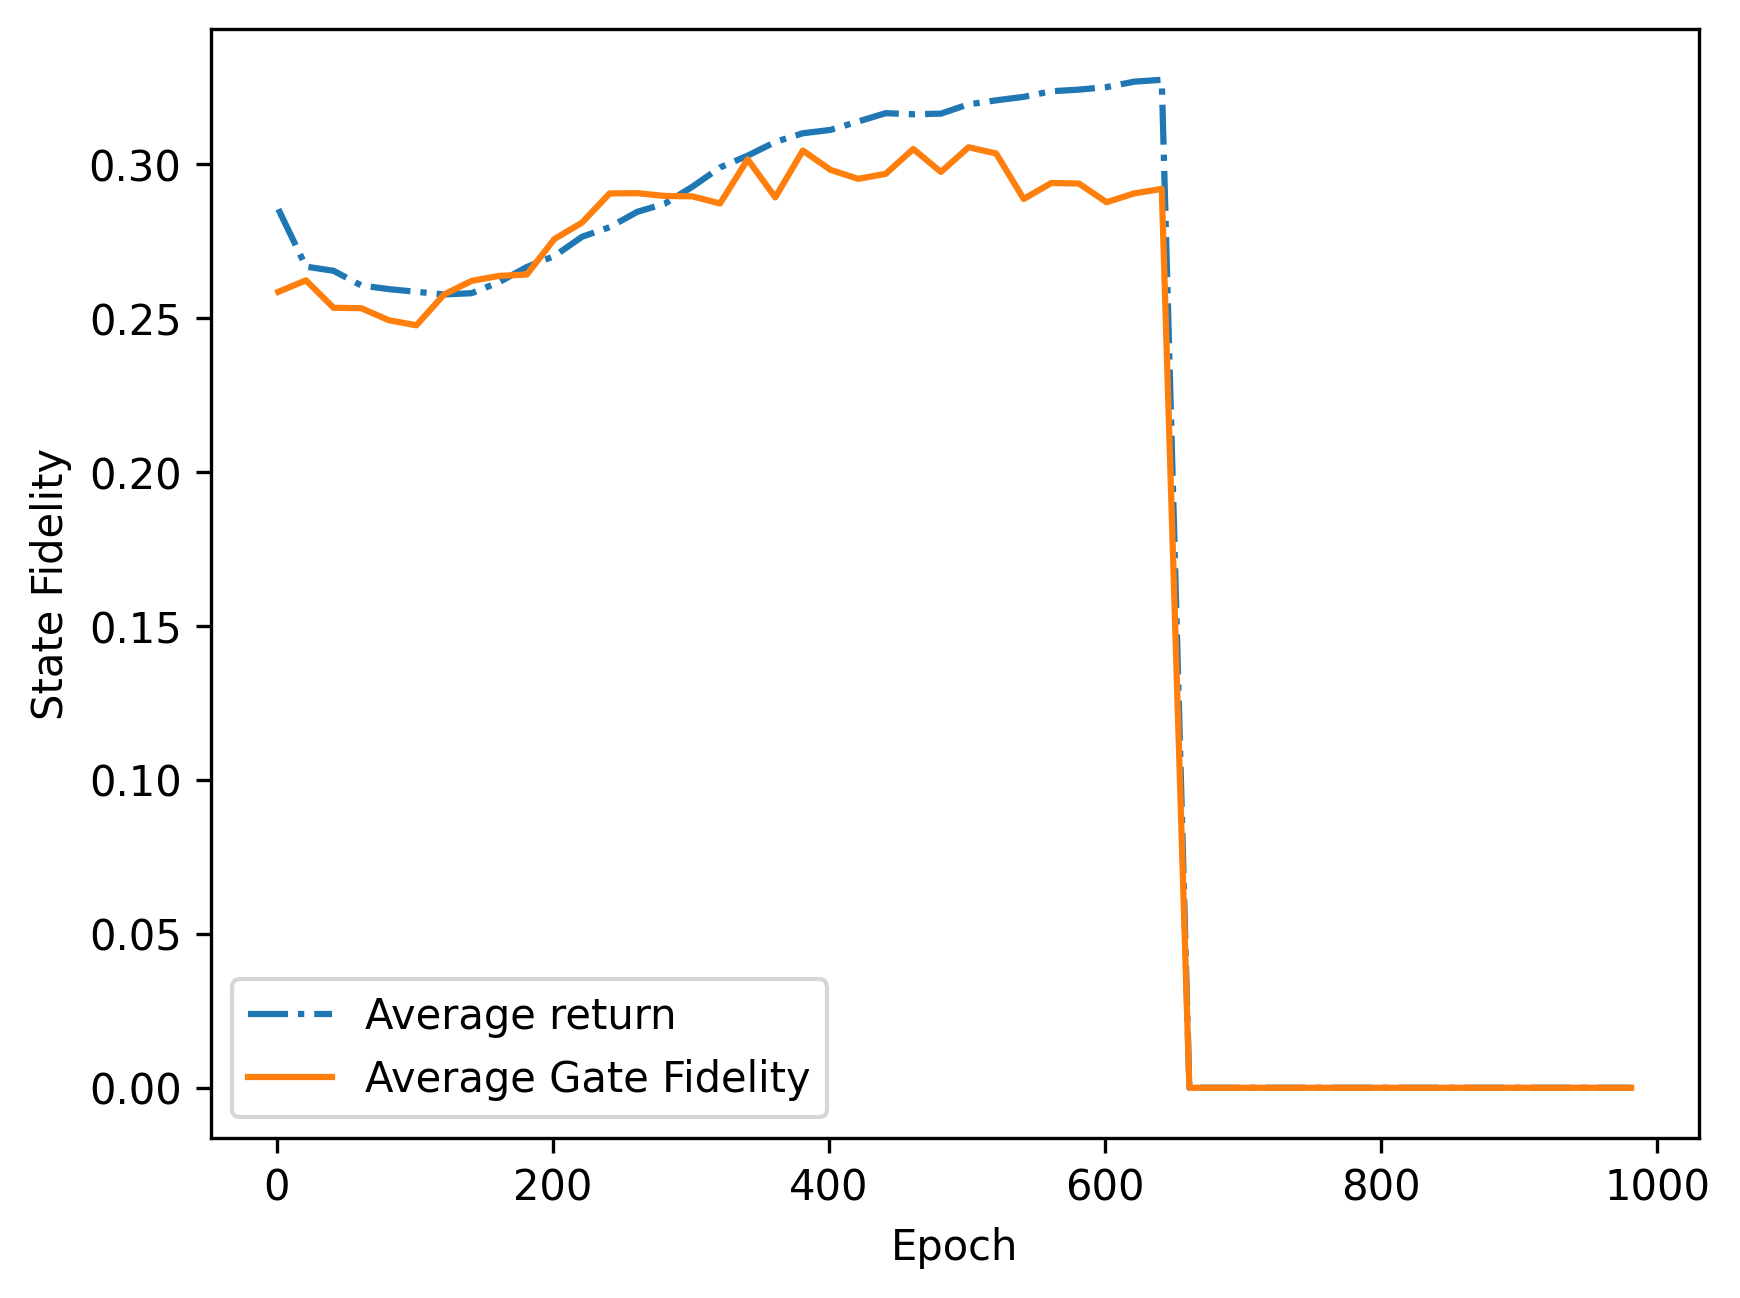

 64%|██████▍   | 641/1000 [04:08<02:23,  2.50it/s]

Maximum fidelity reached so far: 0.314672461369267 at Epoch 348


 64%|██████▍   | 642/1000 [04:08<02:18,  2.58it/s]

Fidelity:  0.2948149901389892


 64%|██████▍   | 643/1000 [04:09<02:15,  2.64it/s]

Fidelity:  0.3067799854752517


 64%|██████▍   | 644/1000 [04:09<02:08,  2.76it/s]

Fidelity:  0.2926361021844217


 64%|██████▍   | 645/1000 [04:09<02:07,  2.79it/s]

Fidelity:  0.2899594534027938


 65%|██████▍   | 646/1000 [04:10<02:06,  2.80it/s]

Fidelity:  0.2907224641092307


 65%|██████▍   | 647/1000 [04:10<02:06,  2.79it/s]

Fidelity:  0.3029259422360947


 65%|██████▍   | 648/1000 [04:11<02:07,  2.76it/s]

Fidelity:  0.2977573894237182


 65%|██████▍   | 649/1000 [04:11<02:08,  2.73it/s]

Fidelity:  0.30343005806139456


 65%|██████▌   | 650/1000 [04:11<02:05,  2.79it/s]

Fidelity:  0.3098907702503829


 65%|██████▌   | 651/1000 [04:12<02:05,  2.79it/s]

Fidelity:  0.2958527344066926


 65%|██████▌   | 652/1000 [04:12<02:02,  2.85it/s]

Fidelity:  0.29360196398304755


 65%|██████▌   | 653/1000 [04:12<02:01,  2.85it/s]

Fidelity:  0.30769076353861596


 65%|██████▌   | 654/1000 [04:13<02:01,  2.86it/s]

Fidelity:  0.28393429446306245


 66%|██████▌   | 655/1000 [04:13<02:01,  2.85it/s]

Fidelity:  0.2884775754219731


 66%|██████▌   | 656/1000 [04:13<02:00,  2.86it/s]

Fidelity:  0.29689033063829307


 66%|██████▌   | 657/1000 [04:14<02:00,  2.86it/s]

Fidelity:  0.2957213332224679


 66%|██████▌   | 658/1000 [04:14<02:12,  2.58it/s]

Fidelity:  0.2969803699291138


KeyboardInterrupt: 

In [811]:
"""
-----------------------------------------------------------------------------------------------------
Training loop
-----------------------------------------------------------------------------------------------------
"""

init_msmt_tensor = torch.tensor(init_msmt, dtype=torch.float32).to(device)
mu_old, sigma_old, _ = model(init_msmt_tensor)

# Initialization
avg_return = np.zeros(n_epochs)
fidelities = np.zeros(n_epochs)

for i in tqdm(range(n_epochs)):

    init_msmt_tensor = torch.tensor(init_msmt, dtype=torch.float32)

    mu, sigma, b = model(init_msmt_tensor)
    

    # Build the covariance matrix
    cov_matrix = torch.diag_embed(sigma**2) # + sigma_eps*torch.eye(n_actions)
    cov_matrix_old = torch.diag_embed(sigma_old**2) # + sigma_eps*torch.eye(n_actions)
        
    # Sample action
    distribution = MultivariateNormal(mu, cov_matrix)
    old_distribution = MultivariateNormal(mu_old, cov_matrix_old)

    action_vector = distribution.sample((batchsize,))
    action_vector_clipped = torch.clamp(action_vector, -1., 1.).squeeze()

    reward = q_env.perform_action(action_vector_clipped, do_benchmark=True)
    optimizer.zero_grad()

    advantage = torch.tensor(reward) - b
    
    # Policy loss
    if use_PPO: # PPO
        ratio = distribution.log_prob(action_vector_clipped).exp() / (old_distribution.log_prob(action_vector_clipped).exp() + sigma_eps)
        clipped_ratio = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
        actor_loss = -torch.mean(torch.min(advantage * ratio, advantage * clipped_ratio))
    
    else:  # REINFORCE
        actor_loss = -torch.mean(advantage * distribution.log_prob(action_vector_clipped))

    critic_loss = torch.mean(advantage ** 2)
    combined_loss = actor_loss + critic_loss_coeff * critic_loss
    # Backward pass
    combined_loss.backward()

    # Clipping gradients (if needed)
    torch.nn.utils.clip_grad_norm_([mu, sigma, b], grad_clip)

    if use_PPO:
        mu_old = mu.data.clone()
        sigma_old = sigma.data.clone()

    optimizer.step()

    # Assuming `q_env` is storing reward history and fidelity history, but this depends on your specific environment logic.
    avg_return[i] = np.mean(q_env.reward_history)
    # print('Average return: ', avg_return[i])
    fidelities[i] = np.mean(q_env.avg_fidelity_history[i])
    print('Fidelity: ', fidelities[i])

    if i % visualization_steps == 0:
        # Clear the current output
        from IPython.display import clear_output
        clear_output(wait=True)

        # Create the figure and plot
        fig, ax = plt.subplots()
        ax.plot(np.arange(1, n_epochs + 1, visualization_steps), avg_return[0:-1:visualization_steps], '-.', label='Average return')
        ax.plot(np.arange(1, n_epochs + 1, visualization_steps), fidelities[0:-1:visualization_steps], label='Average Gate Fidelity')
        ax.set_xlabel("Epoch")
        ax.set_ylabel("State Fidelity")
        ax.legend()
        plt.show()

        # Print additional information
        print("Maximum fidelity reached so far:", np.max(fidelities[:i+1]), "at Epoch", np.argmax(fidelities[:i+1]))

In [ ]:
# print("Actions yielding optimal fidelity:", np.mean(q_env.action_history[np.argmax(fidelities)], axis=0))